# New York City Landcover Analysis

### Introduction

New York City, also known as the concrete jungle, isn't well know for having much green in the city aside from central park. Using landsat imagery we can analyze the surface of NYC and determine how much of the city is concrete, and how much is greenery. 

To do this I'll use Normalized Difference Vegetation index (NDVI) to categorize the surfaces level colors into values.

<img src="ndvi.png" alt="Drawing" style="width: 500px;"/>

### Imports

In [15]:
import pandas as pd
from datetime import datetime
from IPython.display import Image
from IPython.display import HTML
import matplotlib.pyplot as plt
import arcgis
import sys
from arcgis.gis import GIS
from arcgis.raster.functions import apply, clip, remap, colormap
from arcgis.geometry import lengths, areas_and_lengths, project
from arcgis.geometry import Point, Polyline, Polygon, Geometry
from arcgis.geocoding import geocode
from arcgis.features import FeatureLayer
gis = GIS()
#nyc = gis.map('New York City')
#nyc

In [26]:


input_raster_path = r"D:\c\jaipur_2\L1C_T43REK_A028016_20220718T054109.tif"
single_image_layer = arcgis.raster.analytics.copy_raster(input_raster=input_raster_path,output_name="output_imagery_layer",gis=gis)

This GIS does not support raster analysis.


AttributeError: 'NoneType' object has no attribute 'copy_raster'

In [24]:

img_lyr = arcgis.raster.ImageryLayer("D:\c\jaipur_2\L1C_T43REK_A028016_20220718T054109.tif", gis=gis)

In [7]:
map = gis.map()
map.add_layer(img_lyr)

In [17]:
img_lyr

TypeError: argument of type 'NoneType' is not iterable

<ImageryLayer url:"">

In [10]:
landsat_item = gis.content.search('title:Multispectral Landsat', 'Imagery Layer', outside_org=True)[0]
landsat = landsat_item.layers[0]
landsat_item

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri>

### NYC spatial data from ny.gov

In [11]:
nyc_fl = FeatureLayer('https://gisservices.its.ny.gov/arcgis/rest/services/NYS_Civil_Boundaries/FeatureServer/4')
ny_df = pd.DataFrame.spatial.from_layer(nyc_fl)
nyc_df = ny_df.iloc[32:33]
nyc_df

,OBJECTID,NAME,MUNI_TYPE,MUNITYCODE,COUNTY,GNIS_ID,FIPS_CODE,SWIS,POP1990,POP2000,POP2010,POP2020,DOS_LL,DOSLL_DATE,MAP_SYMBOL,CALC_SQ_MI,DATEMOD,SHAPE
32,33,New York,city,1,"New York, Bronx, Kings, Richmond, Queens",2395220,3608151000,650000,7322564,8008278,8175133,8804190,None,NaT,3,470.316754,2019-10-04,"{""rings"": [[[-8222688.7686, 4997925.7896], [-8..."


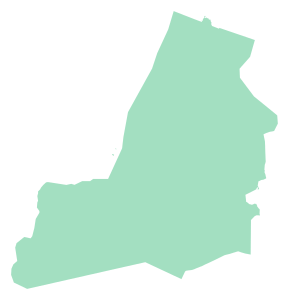

In [12]:
display(nyc_df.spatial)

In [13]:
area = geocode("New York City", out_sr=landsat.properties.spatialReference)[0]
landsat.extent = area['extent']

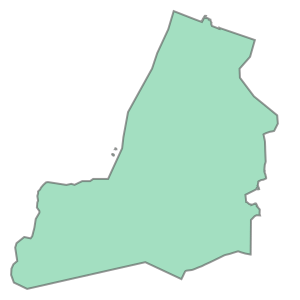

In [14]:
nyc_poly = nyc_df.iloc[0].SHAPE
type(nyc_poly)
display(nyc_poly)

### Landsat image of NYC

In [17]:
selected = landsat.filter_by(where="(Category = 1) AND (cloudcover <=0.05)",
                            time=[datetime(2020, 4, 1), datetime(2020, 6, 30)],
                             geometry=arcgis.geometry.filters.intersects(area['extent']))

df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear", 
                    order_by_fields="AcquisitionDate").sdf
df['AcquisitionDate'] = pd.to_datetime(df['AcquisitionDate'], unit='ms')
df

,OBJECTID,AcquisitionDate,GroupName,CloudCover,DayOfYear,SHAPE
0,2942883,2020-05-12 15:33:06,LC08_L1TP_013032_20200512_20200820_02_T1_MTL,0.0256,32,"{""rings"": [[[-8017114.2764, 5007565.486100003]..."


In [18]:
nyc_image = landsat.filter_by('OBJECTID=2942883')

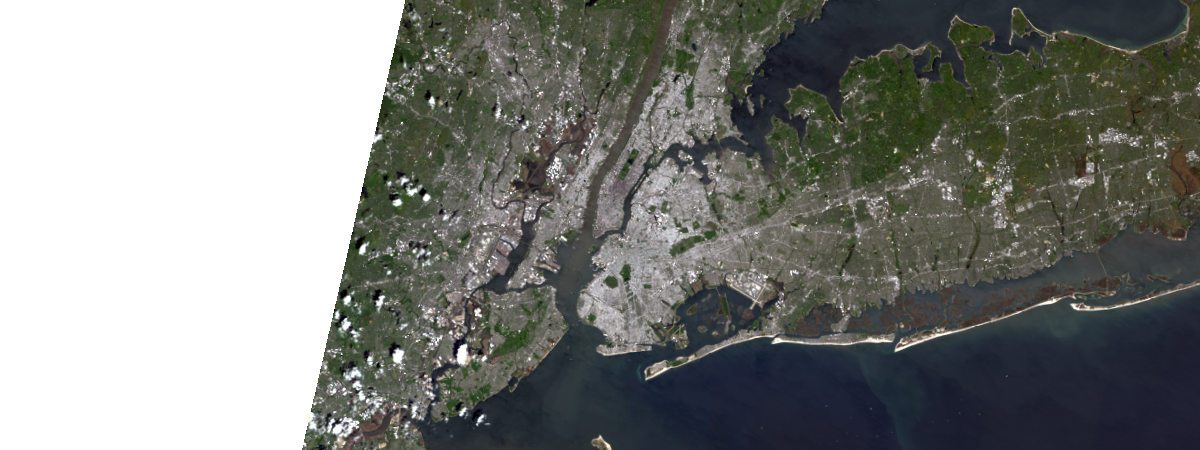

In [19]:
apply(nyc_image, 'Natural Color with DRA')

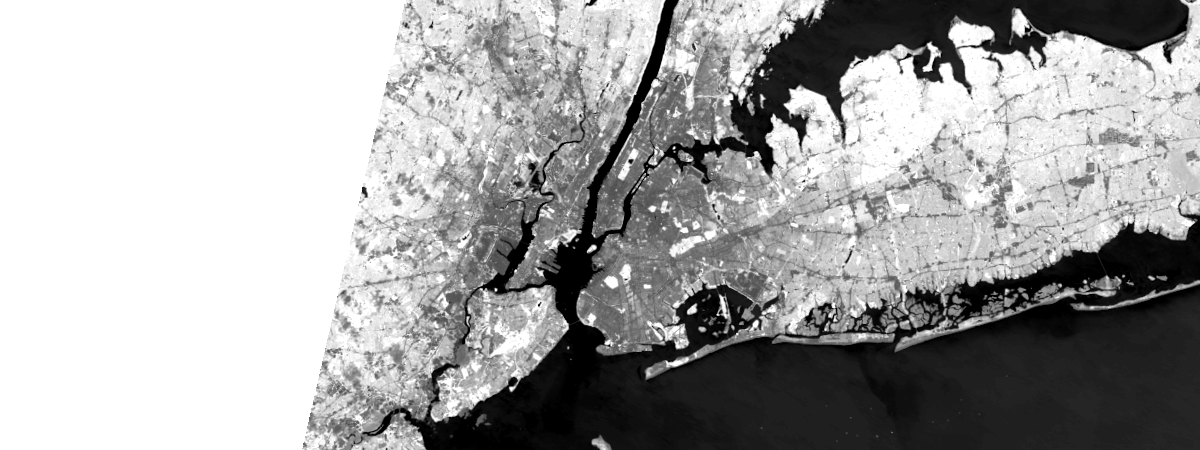

In [20]:
nyc_colorized = apply(nyc_image, 'NDVI Raw')
nyc_colorized

### NYC clip of just city boundaries

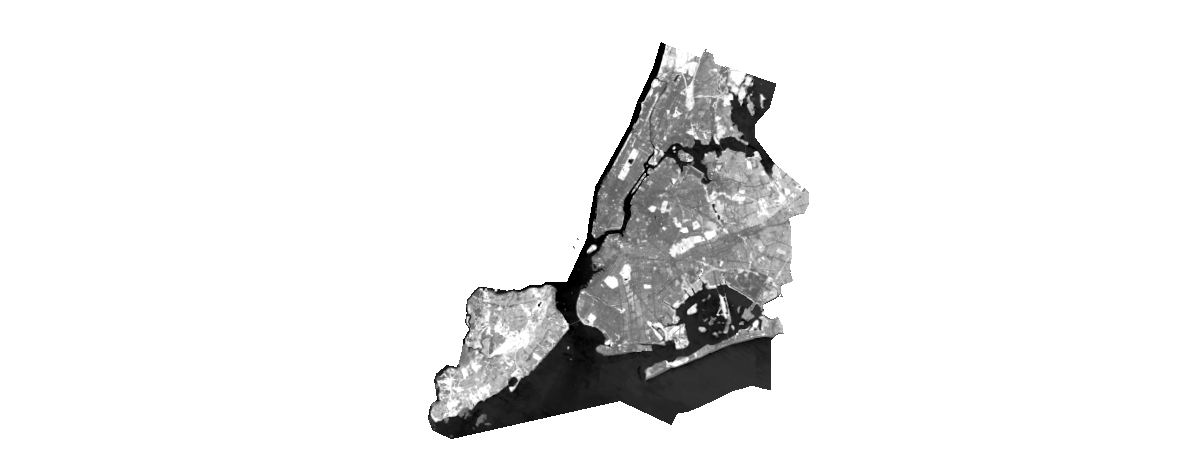

In [22]:
nyc_clip = clip(nyc_colorized,nyc_poly)
nyc_clip.extent = area['extent']
nyc_clip

### NDVI color mask

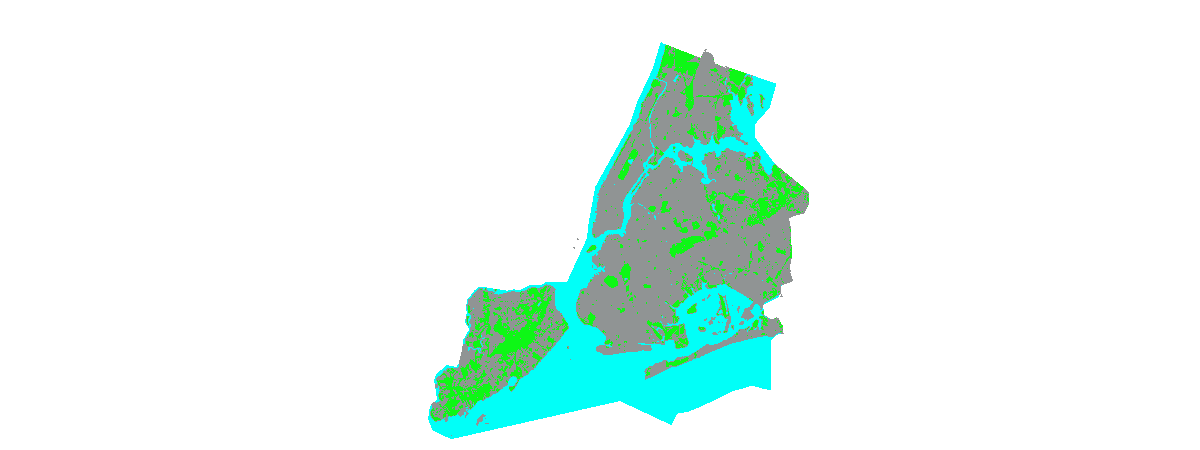

In [13]:
masked = colormap(remap(nyc_clip, 
                        input_ranges=[-1,0,     # water
                                     -0.1, 0.4, # Concrete
                                     0.4, 1],   # Vegetation, Trees      
                        output_values=[1, 2, 3]),
                        colormap=[[1, 1, 255, 248], [2, 144, 148, 148], [3,14,247,22]], astype='u8')

Image(masked.export_image(bbox=area['extent'], size=[1200,450], f='image'))

In [1]:
mask_map = gis.map('New York City')
mask_map.add_layer(masked)
mask_map

NameError: name 'gis' is not defined

### Landcover Analysis

In [15]:
xpixel = (nyc_clip.extent['xmax'] - nyc_clip.extent['xmin']) / 800
ypixel = (nyc_clip.extent['ymax'] - nyc_clip.extent['ymin']) / 400

full_res = masked.compute_histograms(nyc_clip.extent,
                                   pixel_size={'x':xpixel, 'y': ypixel})
total_pix = 0
hist = full_res['histograms'][0]['counts'][0:]
for x in hist[1:]:
    total_pix += x
hist

[0, 57798, 77364, 23875]

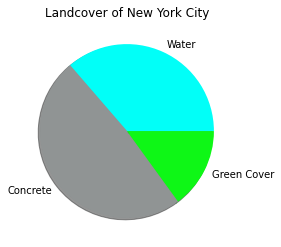

In [16]:
colors=['#0EF716','#01FFF8','#909494']
labels =[ (hist[1]/sum(hist)), (hist[2]/sum(hist)), (hist[3]/sum(hist)) ]
plt.pie(hist, labels=['', 'Water', 'Concrete', 'Green Cover'],colors=colors,
        shadow=True)
plt.title('Landcover of New York City')
plt.show()

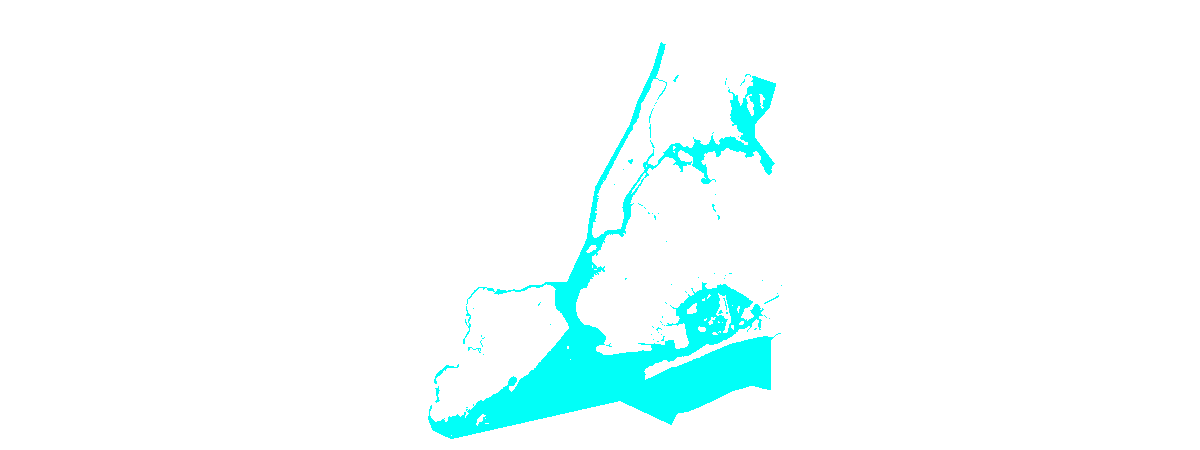

In [20]:
#map varient1
masked_water = colormap(remap(nyc_clip, 
                        input_ranges=[-1,0,     # water
                                     -0.1, 0.4, # Concrete
                                     0.4, 1],   # Vegetation, Trees      
                        output_values=[1, 2, 3]),
                        colormap=[[1, 1, 255, 248], [2, 255, 255, 255], [3,255,255,255]], astype='u8')

Image(masked_water.export_image(bbox=area['extent'], size=[1200,450], f='image'))

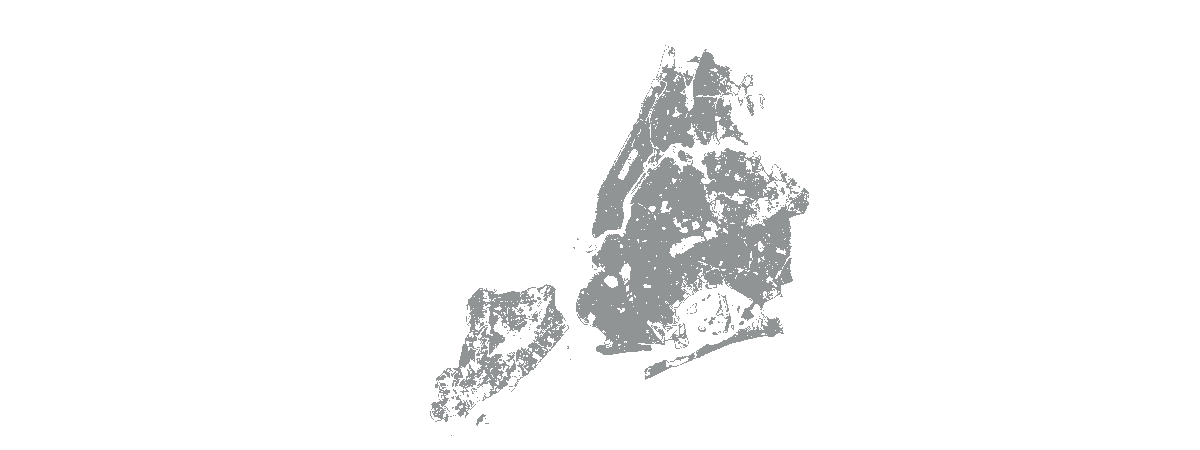

In [21]:
#map varient2
masked_concrete = colormap(remap(nyc_clip, 
                        input_ranges=[-1,0,     # water
                                     -0.1, 0.4, # Concrete
                                     0.4, 1],   # Vegetation, Trees      
                        output_values=[1, 2, 3]),
                        colormap=[[1, 255, 255, 255], [2, 144, 148, 148], [3,255,255,255]], astype='u8')

Image(masked_concrete.export_image(bbox=area['extent'], size=[1200,450], f='image'))

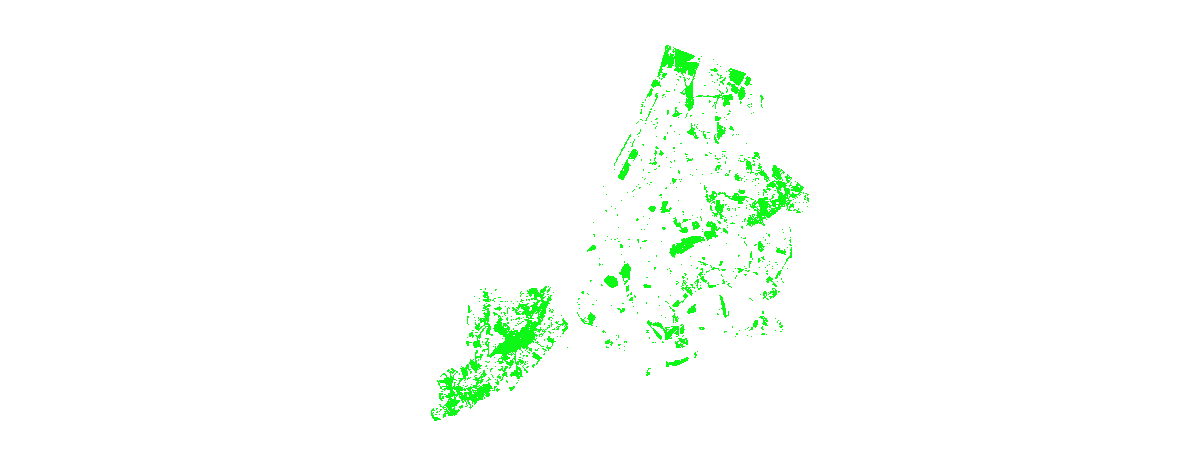

In [22]:
#map varient3
masked_green = colormap(remap(nyc_clip, 
                        input_ranges=[-1,0,     # water
                                     -0.1, 0.4, # Concrete
                                     0.4, 1],   # Vegetation, Trees      
                        output_values=[1, 2, 3]),
                        colormap=[[1, 255, 255, 255], [2, 255, 255, 255], [3,14,247,22]], astype='u8')

Image(masked_green.export_image(bbox=area['extent'], size=[1200,450], f='image'))